# Maskinlæring

Maskinlæring deles ofte i to deler, såkalt supervised og unsupervised, hvor unsupervised metoder forsøker å finne struktur i data på egenhånd, mens supervised maskinlæring brukes for å trene modeller som kan predikere nye utfall.

Det er naturligvis supervised maskinlæring som er i fokus, alt pratet om Kunstig Intelligens refererer til supervised learning.

I denne notebooken skal vi først se litt på unsupervised maskinlæring og nye (dvs gamle) tilnærminger til utliggerdeteksjon på et datasett over lønninger i Boston. Deretter ser vi på supervised maskinlæring for tre ulike typer data

Med et tabulært (strukturert) datasett fra et nettsted for peer-to-peer lån forsøker vi å predikere manglende innfrielse av.

På et tekstdatasett fra offentlig elektronisk postjournal (aka websak) forsøker vi å bruke bag-of-words for å predikere om dokumenttitler kommer fra Statistisk Sentralbyrå eller Fylkesmannen i Sogn og Fjordane.

Til slutt ser vi på maskinlæring med bilder, med et datasett fra IBM som inneholder bilder med 6 forskjellige motiver.

## Outlier detection på lønnsdata

Vi må naturligvis begynne med å lese inn dataene, og sørge for at vi har riktige datatyper. For å konvertere datatyper allerede i innlesing bruker vi `converters` opsjonen i `pd.read_csv`, og spesifiserer vår egen funksjon for å konvertere de litt sære lønnsverdiene (som starter med $ og har komma som tusenskilletegn).

In [1]:
import pandas as pd

In [2]:
def forcefloat(f):
    try:
        rf = float(f.replace(",", ""))
    except:
        rf = 0
    return(rf)

In [3]:
import pandas as pd
emp = pd.read_csv('employeeearningscy18full.csv', 
                  converters={'REGULAR': forcefloat, 
                              'RETRO': forcefloat, 
                              'OTHER': forcefloat, 
                              'OVERTIME': forcefloat,
                              'INJURED': forcefloat,
                              'DETAIL': forcefloat,
                              'QUINN/EDUCATION INCENTIVE': forcefloat,
                             'TOTAL EARNINGS': forcefloat},
                  encoding='latin1')

In [5]:
testdf = emp[['REGULAR', 'OVERTIME']].sample(frac=0.1)

In [6]:
testdf2 = (testdf - testdf.mean() ) / testdf.std()

In [7]:
testdf2

,REGULAR,OVERTIME
21190,-0.037018,-0.374647
5317,-0.684515,-0.378048
4020,0.173446,-0.378048
17469,-1.058350,-0.378048
14305,-0.794257,-0.378048
...,...,...
15851,-1.088097,-0.378048
15129,-0.138070,-0.378048
9949,-1.403440,-0.378048
14486,-1.403440,-0.378048


### Vi begynner med en SVM-basert modell

OneClassSVM er en 

In [13]:
from sklearn.svm import OneClassSVM

Innlesingsprosessen bør ha fjernet alle NaN, men for å være sikker kan vi fylle NaN med 0. I dette tilfellet kan vi føle oss relativt sikker på at manglende lønn tilsvarer 0 kroner, og å fylle NaN med 0 gir mening. Men generelt er dette en felle mange har gått i. Maskinlæringsmodeller takler ikke NaN, og det er generelt to tilnærminger til å håndtere NaN: Enten droppe rader med manglende verdier (`dropna()` er en pandas metode), eller fylle med en verdi. Sistnevnte er i praksis imputering, men ofte en relativt simpel form for imputering som f.eks. å bruke gjennomsnitt.

In [8]:
emp = testdf2.fillna(0)

In [9]:
emp.head()

,REGULAR,OVERTIME
21190,-0.037018,-0.374647
5317,-0.684515,-0.378048
4020,0.173446,-0.378048
17469,-1.058350,-0.378048
14305,-0.794257,-0.378048


In [78]:
import math

In [82]:
import numpy as np

In [11]:
emp.std()

REGULAR     1.0
OVERTIME    1.0
dtype: float64

Her ser vi flyttall in action - snittet skal pr def være 0, men grunnet avrunding er ikke resultatet helt nøyaktig. at tallet er av størrelsesorden e-16 er ikke en tilfeldighet: double-precision flyttall har en presisjon på 16 signifikante siffer.

In [10]:
emp.mean()

REGULAR     1.806465e-17
OVERTIME    2.235029e-16
dtype: float64

### Lage modellen
Det finnes noen hyperparameter som kan tunes, her ser vi ett av de, `gamma`, som i praksis angir hvor jevnt hyperplanet får være. For lineære hyperplan (kernels) blir dette argumentet ignorert. "scale" innebærer at parameteret blir beregnet basert på antallet parametre og variansen til disse.

In [14]:
outlier_svm = OneClassSVM(gamma='scale').fit( emp )

In [15]:
type(outlier_svm)

sklearn.svm._classes.OneClassSVM

In [17]:
emp['outlier_status'] = outlier_svm.fit_predict( emp )

In [18]:
emp.groupby('outlier_status')['outlier_status'].count()

outlier_status
-1    1180
 1    1180
Name: outlier_status, dtype: int64

In [19]:
emp.tail()

,REGULAR,OVERTIME,outlier_status
15851,-1.088097,-0.378048,1
15129,-0.138070,-0.378048,-1
9949,-1.403440,-0.378048,-1
14486,-1.403440,-0.378048,-1
5156,1.010252,-0.378048,-1


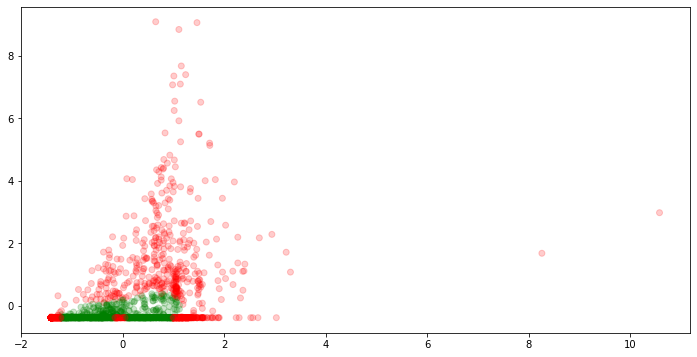

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
figure(num=None, figsize=(12, 6))

clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in emp['outlier_status']]

plt.scatter(emp['REGULAR'], emp['OVERTIME'], c=cs, alpha=0.2 )
#plt.yscale('log')
#plt.xscale('log')

In [28]:
from sklearn.ensemble import IsolationForest

isoforest = IsolationForest(contamination=0.1,
                                         random_state=42)

In [29]:
isoforest.fit(emp)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [30]:
emp['isoforest_status'] = isoforest.fit_predict(emp)

In [31]:
emp[['REGULAR', 'OVERTIME', 'isoforest_status']].head()

,REGULAR,OVERTIME,isoforest_status
21190,-0.037018,-0.374647,1
5317,-0.684515,-0.378048,1
4020,0.173446,-0.378048,1
17469,-1.058350,-0.378048,1
14305,-0.794257,-0.378048,1


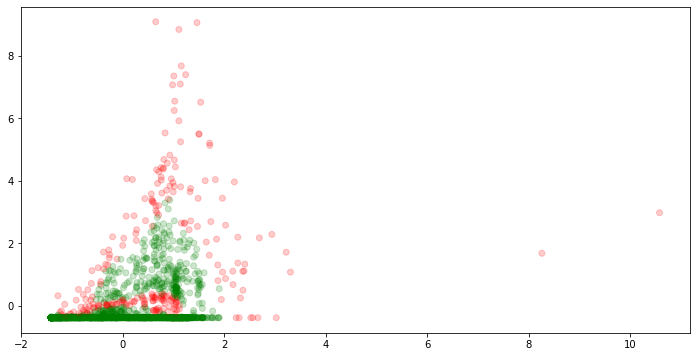

In [34]:
clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in emp['isoforest_status']]

figure(num=None, figsize=(12, 6))


plt.scatter( emp['REGULAR'], emp['OVERTIME'], c=cs, alpha=0.2 )

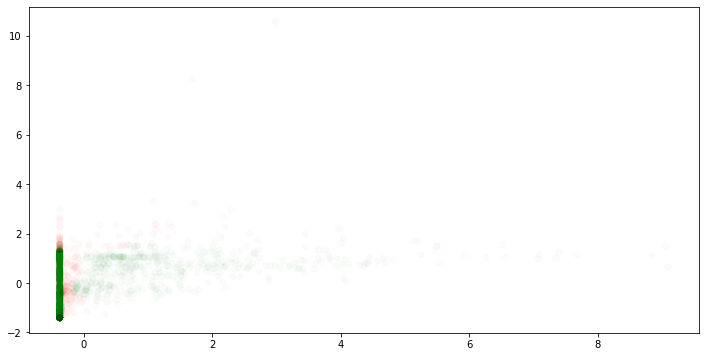

In [35]:
from sklearn.neighbors import LocalOutlierFactor
localout = LocalOutlierFactor(
        n_neighbors=35, contamination=0.1).fit(emp[['REGULAR', 'OVERTIME']])

emp['localout_status'] = localout.fit_predict(emp[['REGULAR', 'OVERTIME']])

cs = [clrs[e] for e in emp['localout_status']]

figure(num=None, figsize=(12, 6))
plt.scatter( emp['OVERTIME'], emp['REGULAR'], c=cs, alpha=0.02 )




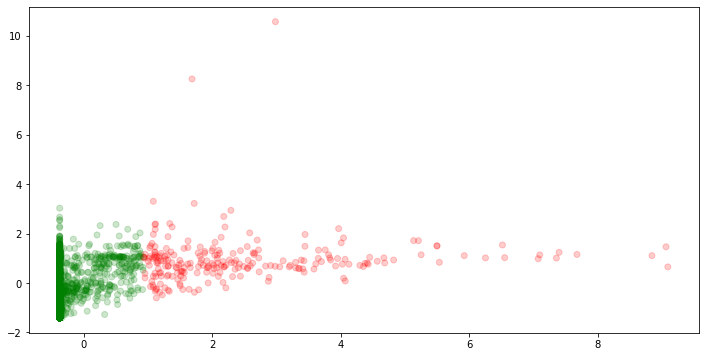

In [37]:
from sklearn.covariance import EllipticEnvelope

ellenv = EllipticEnvelope(contamination=0.1).fit(emp)

emp['ellenv_status'] = ellenv.fit_predict(emp)

cs = [clrs[e] for e in emp['ellenv_status']]

figure(num=None, figsize=(12, 6))
plt.scatter( emp['OVERTIME'], emp['REGULAR'], c=cs, alpha=0.2 )

In [38]:
emp.groupby('ellenv_status')['ellenv_status'].count()

ellenv_status
-1     236
 1    2124
Name: ellenv_status, dtype: int64